<a href="https://colab.research.google.com/github/Davron030901/PyTorch/blob/main/LeNet_for_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

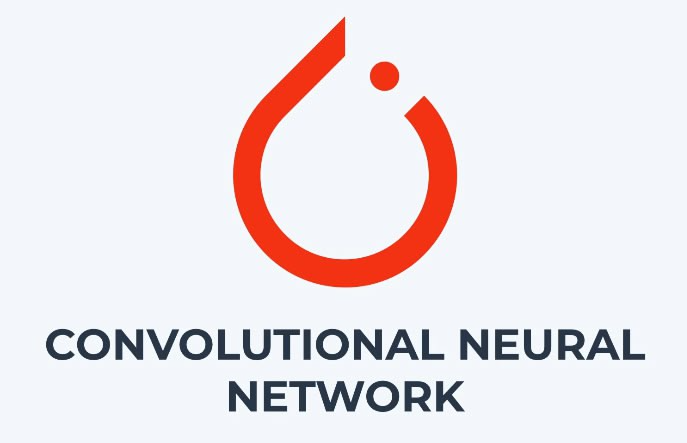

#Dataset LeNet

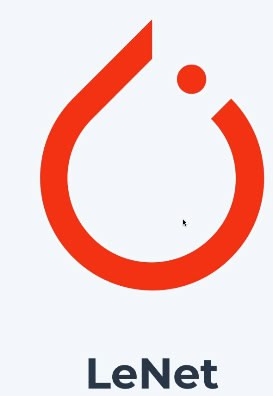

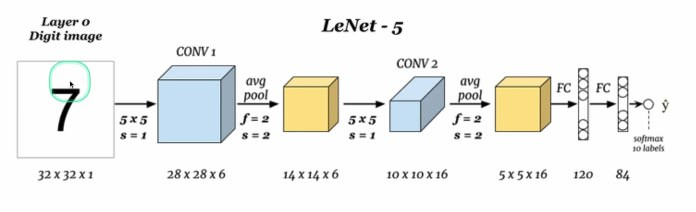

In [ ]:
!wget https://raw.githubusercontent.com/Davron030901/PyTorch/main/data/mnist_png.tar.gz
!tar -xzf mnist_png.tar.gz

--2025-02-01 05:37:39--  https://raw.githubusercontent.com/Davron030901/PyTorch/main/data/mnist_png.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15683414 (15M) [application/octet-stream]
Saving to: ‘mnist_png.tar.gz.2’

mnist_png.tar.gz.2  100%[===================>]  14.96M  --.-KB/s    in 0.08s   

2025-02-01 05:37:39 (181 MB/s) - ‘mnist_png.tar.gz.2’ saved [15683414/15683414]



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
from torch.utils.data import DataLoader,Dataset,random_split
import pathlib

In [ ]:
test_path=pathlib.Path("/content/mnist_png/testing")
train_path=pathlib.Path("/content/mnist_png/training")
imgs=test_path.glob("*/*.png")
print(len(list(imgs)))

10000


(28, 28)


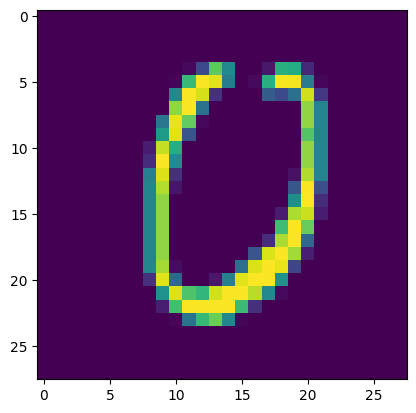

In [ ]:
img=Image.open("/content/mnist_png/testing/0/3185.png")
print(img.size)
plt.imshow(img)

In [ ]:
transform=T.Compose([T.Resize(32),T.ToTensor()])
imge=transform(img)
print(imge.size())
#faqat 1 marta run qilish torch.Size([1, 32, 32])

torch.Size([1, 32, 32])


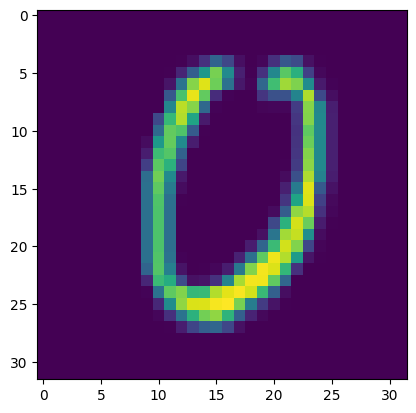

In [ ]:
img=imge.permute(1,2,0)
plt.imshow(img)

In [ ]:
class MNISTDataset(Dataset):
  def __init__(self,path,transform=None):
    # int for cross entryp loss
    self.path_list=list(path.glob("*/*.png"))
    self.transform=transform
  def __len__(self):
    return len(self.path_list)
  def __getitem__(self,idx):
    img=Image.open(self.path_list[idx])
    label=int(self.path_list[idx].parent.name)
    if transform!= None:
      img=transform(img)
    return img,int(label)

In [ ]:
test_dataset=MNISTDataset(test_path,transform)
train_dataset=MNISTDataset(train_path,transform)
train_data=DataLoader(train_dataset,batch_size=64,shuffle=True)
test_data=DataLoader(test_dataset,batch_size=64,shuffle=True)

In [ ]:
for x,y in test_data:
  print(x.shape)
  print(y)
  break

torch.Size([64, 1, 32, 32])
tensor([0, 5, 6, 8, 8, 5, 6, 4, 0, 7, 5, 2, 8, 9, 3, 0, 4, 5, 4, 7, 4, 4, 8, 3,
        4, 5, 9, 0, 6, 4, 4, 7, 2, 2, 0, 1, 4, 0, 7, 5, 6, 7, 9, 0, 1, 6, 7, 8,
        8, 1, 6, 8, 1, 3, 2, 2, 3, 6, 9, 3, 5, 3, 5, 6])


In [ ]:
torch.Size([64, 1, 32, 32])

torch.Size([64, 1, 32, 32])

In [ ]:
from torch import nn
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    # 32X32X1
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6,
                           kernel_size = 5, stride = 1, padding = 0)
    # 28X28X6
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16,
                           kernel_size = 5, stride = 1, padding = 0)
    # 14X14X6
    self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 120,
                           kernel_size = 5, stride = 1, padding = 0)
    # 10X10X16

    # AVG POLL 5X5X16

    self.linear1 = nn.Linear(120, 84)
    self.linear2 = nn.Linear(84, 10)
    self.tanh = nn.Tanh()
    self.avgpool = nn.AvgPool2d(kernel_size = 2, stride = 2)

  def forward(self, x):
    # 32X32X1
    x = self.conv1(x)
    x = self.tanh(x)
    # 28X28X6
    x = self.avgpool(x)
    # 14x14x6
    x = self.conv2(x)
    # 10x10x16
    x = self.tanh(x)
    x = self.avgpool(x)
    # 5x5x16
    x = self.conv3(x)
    # 1x1x120

    x = self.tanh(x)

    x = x.reshape(x.shape[0], -1)
    # 120
    x = self.linear1(x)
    # 84
    x = self.tanh(x)
    # 84
    x = self.linear2(x)
    # 10
    return x

In [ ]:
model=LeNet()

In [ ]:
# loss and optimizer
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
print(device)
print(torch.cuda.is_available())

cuda
True


In [ ]:
class Trainer:
    def __init__(self, model,train_dataloader, test_dataloader, criterion, optimizer, epochs=3):
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.criterion = criterion
        self.optimizer = optimizer

        self.epochs = epochs
        self.history = {'loss':[],'acc':[],'val_loss':[],'val_acc':[]}

    def train_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.train_dataloader)
        for i, (data,label) in enumerate(tqdm(self.train_dataloader)):
            data = data.to(device)
            label = label.to(device)
            # prediction model
            output = self.model(data)
            # find loss
            loss = self.criterion(output, label)

            sum_loss += loss.item()
            n_corrects = (output.argmax(axis=1)==label).sum().item()
            sum_accuracy += n_corrects/label.size(0)

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()


        train_loss = sum_loss/n
        train_accuracy = sum_accuracy/n

        self.history['loss'].append(train_loss)
        self.history['acc'].append(train_accuracy)

        return train_loss, train_accuracy

    def validation_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.test_dataloader)
        for i, (data,label) in enumerate(tqdm(self.test_dataloader)):
            data = data.to(device)
            label = label.to(device)
            # prediction model
            output = self.model(data)
            # find loss
            loss = self.criterion(output, label)
            n_corrects = (output.argmax(axis=1)==label).sum().item()

            sum_loss += loss.item()
            sum_accuracy += n_corrects/label.size(0)

        val_loss = sum_loss/n
        val_accuracy = sum_accuracy/n

        self.history['val_loss'].append(val_loss)
        self.history['val_acc'].append(val_accuracy)

        return val_loss, val_accuracy

    def train(self):
        for epoch in range(self.epochs):
            train_loss, train_acc = self.train_loop()
            val_loss, val_acc = self.validation_loop()
            print()
            print(f'Epoch[{epoch+1}/{self.epochs}] \t train_loss: {train_loss:.5f}, train_acc: {train_acc:.2f} \t val_loss: {val_loss:.5f} \t val_acc: {val_acc:.2}')

In [ ]:
!pip install tqdm

In [ ]:
trainer = Trainer(
    model = model.to(device),
    train_dataloader=train_data,
    test_dataloader=test_data,
    criterion=criterion,
    optimizer=optimizer,
    epochs=5,
)

In [ ]:
from tqdm import tqdm
trainer.train()

100%|██████████| 157/157 [00:04<00:00, 34.70it/s]



Epoch[1/5] 	 train_loss: 0.28271, train_acc: 0.92 	 val_loss: 0.11614 	 val_acc: 0.97


100%|██████████| 157/157 [00:03<00:00, 42.63it/s]



Epoch[2/5] 	 train_loss: 0.09099, train_acc: 0.97 	 val_loss: 0.07562 	 val_acc: 0.98


100%|██████████| 157/157 [00:03<00:00, 43.09it/s]



Epoch[3/5] 	 train_loss: 0.06044, train_acc: 0.98 	 val_loss: 0.05824 	 val_acc: 0.98


100%|██████████| 157/157 [00:04<00:00, 36.60it/s]



Epoch[4/5] 	 train_loss: 0.04542, train_acc: 0.99 	 val_loss: 0.05291 	 val_acc: 0.98


100%|██████████| 157/157 [00:03<00:00, 42.51it/s]


Epoch[5/5] 	 train_loss: 0.03583, train_acc: 0.99 	 val_loss: 0.04669 	 val_acc: 0.98


In [ ]:
print(f"history: \t{trainer.history}")
print(f"loss: \t{trainer.history['loss']}")
print(f"acc: \t{trainer.history['acc']}")
print(f"val_loss: \t{trainer.history['val_loss']}")
print(f"val_acc: \t{trainer.history['val_acc']}")

history: 	{'loss': [0.28271210099012456, 0.09099335331163967, 0.06044041568801593, 0.045424178982628134, 0.035827961595811406], 'acc': [0.9188432835820896, 0.9724147121535182, 0.9816098081023454, 0.9860241204690832, 0.9888226279317697], 'val_loss': [0.11613643353294795, 0.0756223753248905, 0.05824360332991572, 0.05291014600539236, 0.04668790933299383], 'val_acc': [0.9650676751592356, 0.9757165605095541, 0.9821855095541401, 0.9837778662420382, 0.984375]}
loss: 	[0.28271210099012456, 0.09099335331163967, 0.06044041568801593, 0.045424178982628134, 0.035827961595811406]
acc: 	[0.9188432835820896, 0.9724147121535182, 0.9816098081023454, 0.9860241204690832, 0.9888226279317697]
val_loss: 	[0.11613643353294795, 0.0756223753248905, 0.05824360332991572, 0.05291014600539236, 0.04668790933299383]
val_acc: 	[0.9650676751592356, 0.9757165605095541, 0.9821855095541401, 0.9837778662420382, 0.984375]


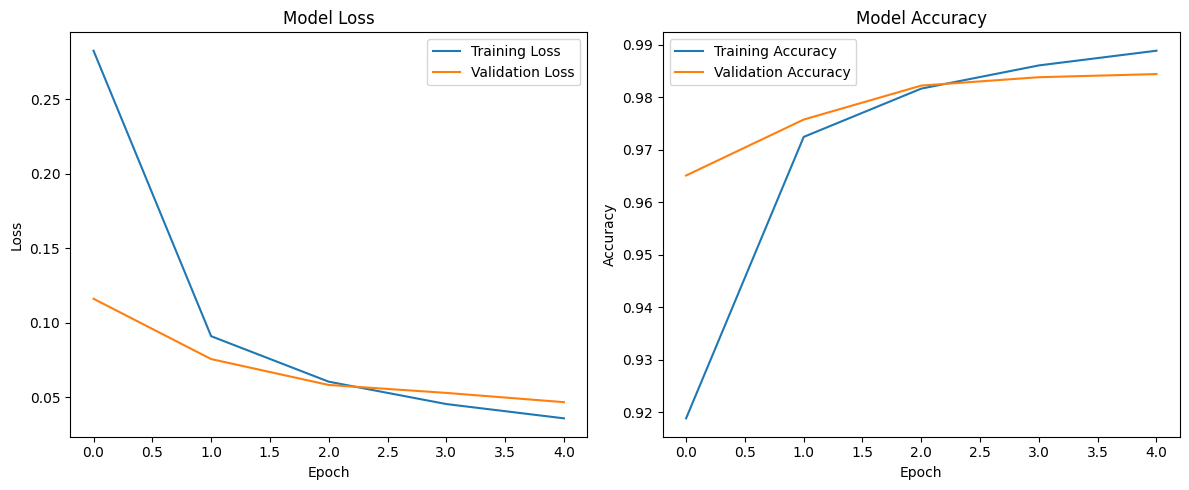

In [ ]:
# Treningdagi va validatsiyadagi yo'qotish (loss) qiymatlarini chizish
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(trainer.history['loss'], label='Training Loss')
plt.plot(trainer.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Treningdagi va validatsiyadagi aniqlik (accuracy) qiymatlarini chizish
plt.subplot(1, 2, 2)
plt.plot(trainer.history['acc'], label='Training Accuracy')
plt.plot(trainer.history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()